# Add Sharadar Metadata to LSEG Fundamentals CSV

This notebook enriches your LSEG fundamentals CSV with Sharadar ticker metadata (exchange, category, ADR status, sector, industry, market cap scale, etc.) so that all information is available in a single database table for Pipeline filtering.

## Metadata Columns Added

The following columns will be added with `sharadar_` prefix:

- `sharadar_exchange`: Exchange (NYSE, NASDAQ, NYSEMKT, etc.)
- `sharadar_category`: Stock category (Domestic Common Stock, ADR, ETF, etc.)
- `sharadar_is_adr`: Boolean ADR flag (1=True, 0=False)
- `sharadar_location`: Company location (USA, etc.)
- `sharadar_sector`: Sharadar sector
- `sharadar_industry`: Sharadar industry
- `sharadar_sicsector`: SIC sector
- `sharadar_sicindustry`: SIC industry
- `sharadar_scalemarketcap`: Market cap scale (1-6: Nano to Mega)

## Author
Kamran Sokhanvari / Hidden Point Capital

## 1. Setup and Configuration

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Configuration
CSV_DIR = '/data/csv/'  # Directory containing LSEG fundamentals CSV files
SHARADAR_BUNDLE = 'sharadar'  # Sharadar bundle name

# Auto-detect newest CSV file by date in filename
print("Auto-detecting newest CSV file...")
INPUT_CSV = find_newest_csv(directory=CSV_DIR)

if INPUT_CSV is None:
    raise FileNotFoundError(f"No CSV files found in {CSV_DIR}")

# Auto-generate output filename
OUTPUT_CSV = generate_output_filename(INPUT_CSV)

print(f"Input CSV: {INPUT_CSV}")
print(f"Output CSV: {OUTPUT_CSV}")
print(f"Sharadar Bundle: {SHARADAR_BUNDLE}")

Input CSV: /data/csv/20091231_20251118.csv
Output CSV: /data/csv/20091231_20251118_with_metadata.csv
Sharadar Bundle: sharadar


## 2. Load Sharadar Ticker Metadata

In [3]:
# Import functions from the script (single source of truth with deduplication fix)
import sys
sys.path.insert(0, '/app/examples/lseg_fundamentals')
from add_sharadar_metadata_to_fundamentals import load_sharadar_tickers, add_metadata_to_fundamentals

print("✓ Imported functions from add_sharadar_metadata_to_fundamentals.py")
print("  - load_sharadar_tickers() - loads and deduplicates Sharadar metadata")
print("  - add_metadata_to_fundamentals() - merges metadata with fundamentals")
print("\n⚠️  DEDUPLICATION FIX: Handles multiple entries per ticker (keeps first occurrence)")

✓ Imported functions from add_sharadar_metadata_to_fundamentals.py
  - load_sharadar_tickers() - loads and deduplicates Sharadar metadata
  - add_metadata_to_fundamentals() - merges metadata with fundamentals

⚠️  DEDUPLICATION FIX: Handles multiple entries per ticker (keeps first occurrence)


In [4]:
# Load Sharadar metadata
sharadar_metadata = load_sharadar_tickers(SHARADAR_BUNDLE)

print(f"\nMetadata shape: {sharadar_metadata.shape}")
print(f"\nColumns: {list(sharadar_metadata.columns)}")
print(f"\nFirst 5 rows:")
sharadar_metadata.head()

Loading Sharadar tickers from bundle: sharadar
Loading from: /root/.zipline/data/sharadar/2025-11-23T04;09;32.033611/fundamentals/tickers.h5
Loaded 60303 tickers
After deduplication: 30801 unique tickers

Metadata shape: (30801, 10)

Columns: ['Symbol', 'exchange', 'category', 'location', 'sector', 'industry', 'sicsector', 'sicindustry', 'scalemarketcap', 'is_adr']

First 5 rows:


,Symbol,exchange,category,location,sector,industry,sicsector,sicindustry,scalemarketcap,is_adr
None,,,,,,,,,,
0,IFLR,NYSEARCA,ETF,Illinois; U.S.A,None,None,None,None,None,0
1,CAIQ,NASDAQ,ETF,Illinois; U.S.A,None,None,None,None,None,0
2,ESBG,NYSEARCA,ETF,Illinois; U.S.A,None,None,None,None,None,0
3,TXXD,NASDAQ,ETF,Wisconsin; U.S.A,None,None,None,None,None,0
4,MNZL,NASDAQ,ETF,Pennsylvania; U.S.A,None,None,None,None,None,0


## 3. Metadata Summary Statistics

EXCHANGE DISTRIBUTION
exchange
NASDAQ      15607
NYSE         8483
NYSEARCA     3768
NYSEMKT      1494
BATS         1437
OTC             6
INDEX           5
None            1
Name: count, dtype: int64


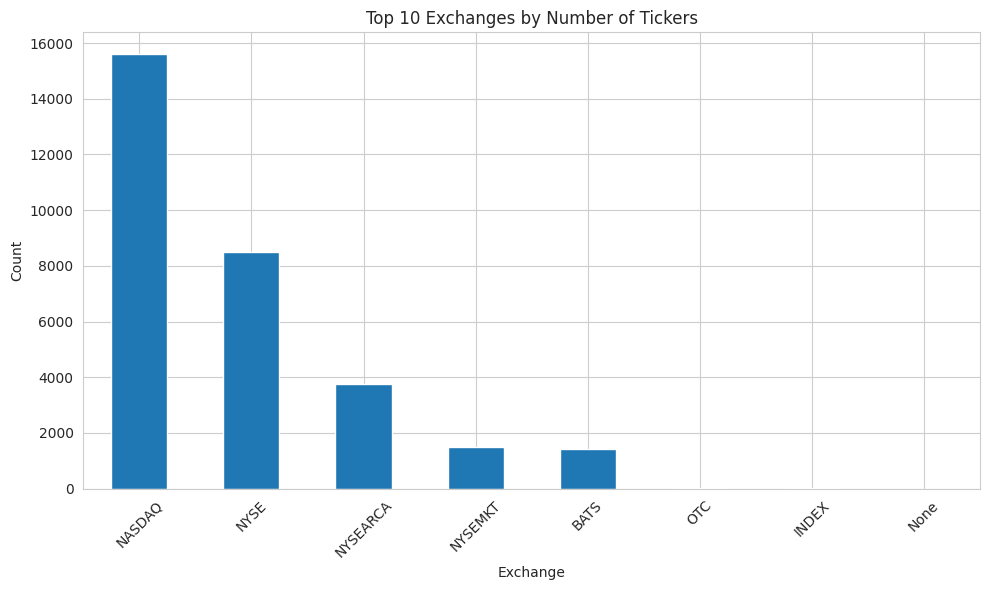

In [5]:
# Exchange distribution
print("=" * 80)
print("EXCHANGE DISTRIBUTION")
print("=" * 80)
print(sharadar_metadata['exchange'].value_counts())

# Plot
plt.figure(figsize=(10, 6))
sharadar_metadata['exchange'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Exchanges by Number of Tickers')
plt.xlabel('Exchange')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

CATEGORY DISTRIBUTION
category
Domestic Common Stock                    13391
ETF                                       6562
Domestic Common Stock Primary Class       2028
ADR Common Stock                          1814
Domestic Common Stock Warrant             1465
Domestic Common Stock Secondary Class     1182
Domestic Preferred Stock                  1115
CEF                                       1068
ETD                                        479
ETN                                        412
Canadian Common Stock                      366
ADR Common Stock Primary Class             257
ADR Common Stock Warrant                   224
ADR Common Stock Secondary Class           151
ADR Preferred Stock                         90
CEF Preferred                               69
CEF Warrant                                 52
UNIT                                        24
ETMF                                        18
Canadian Common Stock Primary Class         15
Canadian Common Stock Warrant

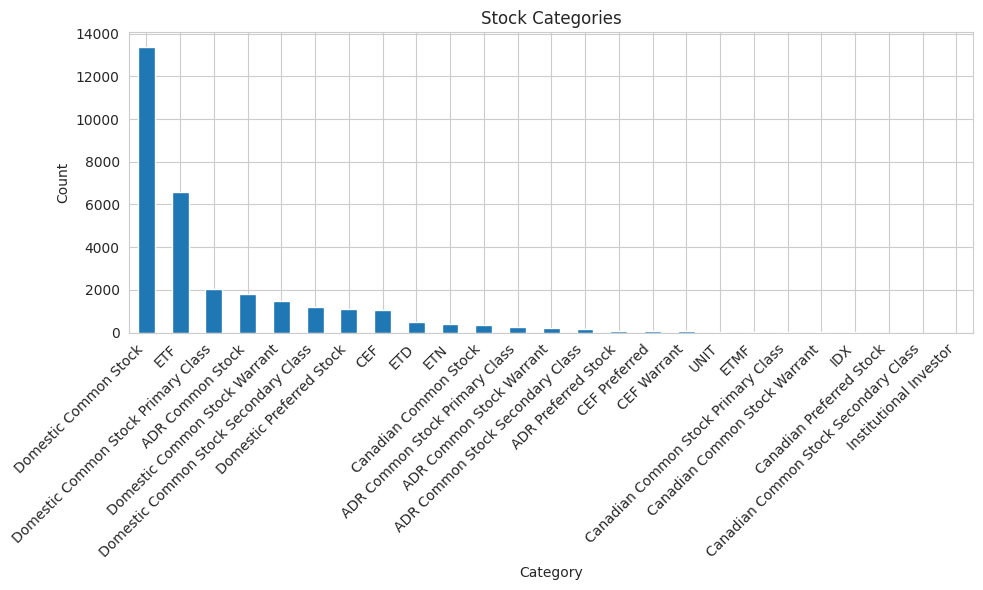

In [6]:
# Category distribution
print("=" * 80)
print("CATEGORY DISTRIBUTION")
print("=" * 80)
print(sharadar_metadata['category'].value_counts())

# Plot
plt.figure(figsize=(10, 6))
sharadar_metadata['category'].value_counts().plot(kind='bar')
plt.title('Stock Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

ADR DISTRIBUTION
Non-ADRs: 28,265
ADRs: 2,536


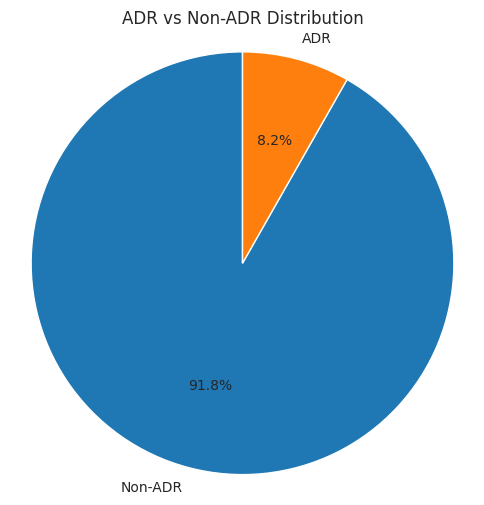

In [7]:
# ADR distribution
print("=" * 80)
print("ADR DISTRIBUTION")
print("=" * 80)
adr_counts = sharadar_metadata['is_adr'].value_counts()
print(f"Non-ADRs: {adr_counts.get(0, 0):,}")
print(f"ADRs: {adr_counts.get(1, 0):,}")

# Plot
plt.figure(figsize=(6, 6))
labels = ['Non-ADR', 'ADR']
sizes = [adr_counts.get(0, 0), adr_counts.get(1, 0)]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('ADR vs Non-ADR Distribution')
plt.axis('equal')
plt.show()

SECTOR DISTRIBUTION
sector
None                      8824
Industrials               4257
Technology                3697
Healthcare                3251
Financial Services        3101
Consumer Cyclical         2055
Communication Services    1240
Real Estate               1095
Basic Materials           1048
Energy                     969
Consumer Defensive         842
Utilities                  422
Name: count, dtype: int64


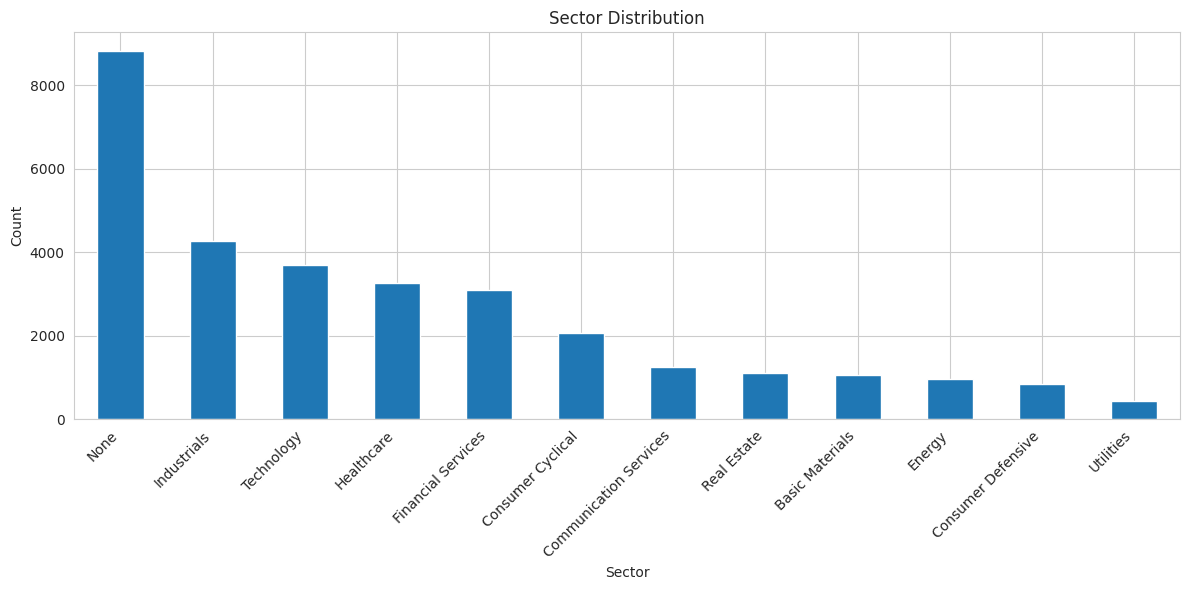

In [8]:
# Sector distribution
if 'sector' in sharadar_metadata.columns:
    print("=" * 80)
    print("SECTOR DISTRIBUTION")
    print("=" * 80)
    print(sharadar_metadata['sector'].value_counts())
    
    # Plot
    plt.figure(figsize=(12, 6))
    sharadar_metadata['sector'].value_counts().plot(kind='bar')
    plt.title('Sector Distribution')
    plt.xlabel('Sector')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

MARKET CAP SCALE DISTRIBUTION
scalemarketcap
1 - Nano      1527
2 - Micro     4488
3 - Small     6137
4 - Mid       3384
5 - Large     1739
6 - Mega        92
None         13434
Name: count, dtype: int64


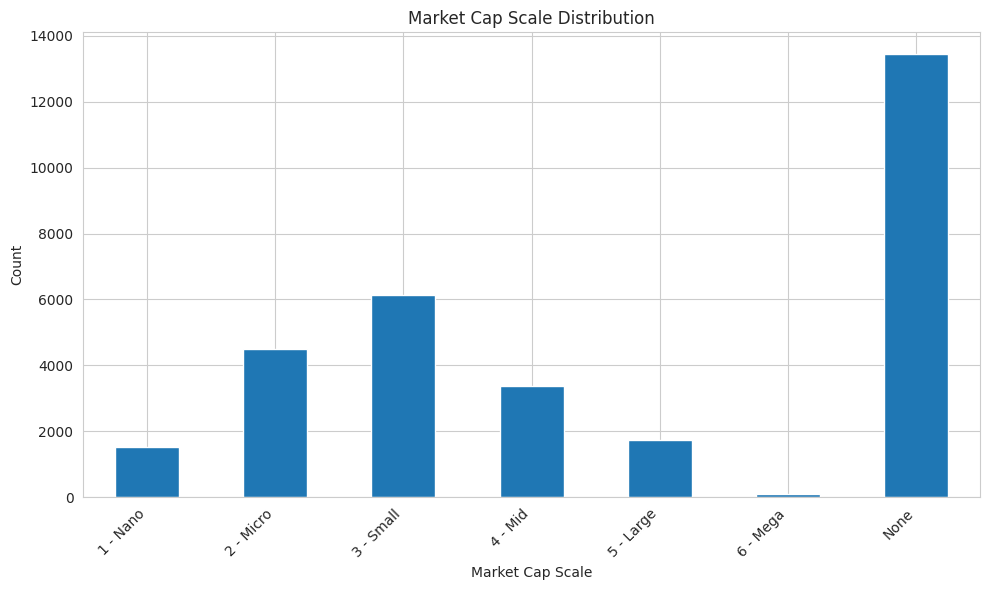

In [9]:
# Market cap scale distribution
if 'scalemarketcap' in sharadar_metadata.columns:
    print("=" * 80)
    print("MARKET CAP SCALE DISTRIBUTION")
    print("=" * 80)
    print(sharadar_metadata['scalemarketcap'].value_counts().sort_index())
    
    # Plot
    plt.figure(figsize=(10, 6))
    sharadar_metadata['scalemarketcap'].value_counts().sort_index().plot(kind='bar')
    plt.title('Market Cap Scale Distribution')
    plt.xlabel('Market Cap Scale')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 4. Load LSEG Fundamentals CSV

In [10]:
# Load LSEG fundamentals
print(f"Loading LSEG fundamentals from: {INPUT_CSV}")
fundamentals = pd.read_csv(INPUT_CSV)

print(f"\nLoaded {len(fundamentals):,} rows, {len(fundamentals.columns)} columns")
print(f"\nColumns: {list(fundamentals.columns)}")

if 'Date' in fundamentals.columns:
    print(f"\nDate range: {fundamentals['Date'].min()} to {fundamentals['Date'].max()}")
    print(f"Unique dates: {fundamentals['Date'].nunique():,}")

if 'Symbol' in fundamentals.columns:
    print(f"Unique symbols: {fundamentals['Symbol'].nunique():,}")

print(f"\nFirst 5 rows:")
fundamentals.head()

Loading LSEG fundamentals from: /data/csv/20091231_20251118.csv

Loaded 9,010,487 rows, 38 columns

Columns: ['Date', 'Symbol', 'Instrument', 'RefPriceClose', 'RefVolume', 'CompanyCommonName', 'EnterpriseValue_DailyTimeSeries_', 'CompanyMarketCap', 'GICSSectorName', 'FOCFExDividends_Discrete', 'InterestExpense_NetofCapitalizedInterest', 'Debt_Total', 'EarningsPerShare_Actual', 'EarningsPerShare_SmartEstimate_prev_Q', 'EarningsPerShare_ActualSurprise', 'EarningsPerShare_SmartEstimate_current_Q', 'LongTermGrowth_Mean', 'PriceTarget_Median', 'CombinedAlphaModelSectorRank', 'CombinedAlphaModelSectorRankChange', 'CombinedAlphaModelRegionRank', 'EarningsQualityRegionRank_Current', 'EnterpriseValueToEBIT_DailyTimeSeriesRatio_', 'EnterpriseValueToEBITDA_DailyTimeSeriesRatio_', 'EnterpriseValueToSales_DailyTimeSeriesRatio_', 'Dividend_Per_Share_SmartEstimate', 'CashCashEquivalents_Total', 'ForwardPEG_DailyTimeSeriesRatio_', 'PriceEarningsToGrowthRatio_SmartEstimate_', 'Recommendation_Median_1_5

,Date,Symbol,Instrument,RefPriceClose,RefVolume,CompanyCommonName,EnterpriseValue_DailyTimeSeries_,CompanyMarketCap,GICSSectorName,FOCFExDividends_Discrete,InterestExpense_NetofCapitalizedInterest,Debt_Total,EarningsPerShare_Actual,EarningsPerShare_SmartEstimate_prev_Q,EarningsPerShare_ActualSurprise,EarningsPerShare_SmartEstimate_current_Q,LongTermGrowth_Mean,PriceTarget_Median,CombinedAlphaModelSectorRank,CombinedAlphaModelSectorRankChange,CombinedAlphaModelRegionRank,EarningsQualityRegionRank_Current,EnterpriseValueToEBIT_DailyTimeSeriesRatio_,EnterpriseValueToEBITDA_DailyTimeSeriesRatio_,EnterpriseValueToSales_DailyTimeSeriesRatio_,Dividend_Per_Share_SmartEstimate,CashCashEquivalents_Total,ForwardPEG_DailyTimeSeriesRatio_,PriceEarningsToGrowthRatio_SmartEstimate_,Recommendation_Median_1_5_,ReturnOnEquity_SmartEstimat,ReturnOnAssets_SmartEstimate,ForwardPriceToCashFlowPerShare_DailyTimeSeriesRatio_,ForwardPriceToSalesPerShare_DailyTimeSeriesRatio_,ForwardEnterpriseValueToOperatingCashFlow_DailyTimeSeriesRatio_,GrossProfitMargin_ActualSurprise,Estpricegrowth_percent,TradeDate
0,2009-12-31,A,A.N,22.217753,NaN,Agilent Technologies Inc,1.125719e+10,1.083819e+10,Health Care,183000000.0,21000000.0,2.904000e+09,0.32,NaN,37.404,NaN,15.0,33.0,40.0,NaN,41.0,40.0,32.535225,22.335690,2.512204,NaN,2.479000e+09,0.993966,NaN,2.0,NaN,NaN,13.785078,1.609831,20.022743,4.081,0.485299,2009-12-31
1,2010-01-04,A,A.N,22.382223,894600.0,Agilent Technologies Inc,1.133742e+10,1.091842e+10,Health Care,183000000.0,21000000.0,2.904000e+09,0.32,NaN,37.404,NaN,15.0,33.0,44.0,2.0,43.0,40.0,32.767107,22.494879,2.530109,NaN,2.479000e+09,0.999386,NaN,2.0,NaN,NaN,13.857960,1.620728,20.123099,4.081,0.474384,2010-01-04
2,2010-01-05,A,A.N,22.139094,828100.0,Agilent Technologies Inc,1.121882e+10,1.079982e+10,Health Care,183000000.0,21000000.0,2.904000e+09,0.32,NaN,37.404,NaN,15.0,33.0,42.0,-1.0,41.0,40.0,32.424325,22.259556,2.503641,NaN,2.479000e+09,0.988052,NaN,2.0,NaN,NaN,13.700236,1.602871,19.902142,4.081,0.490576,2010-01-05
3,2010-01-06,A,A.N,22.060434,852400.0,Agilent Technologies Inc,1.118232e+10,1.076332e+10,Health Care,183000000.0,21000000.0,2.904000e+09,0.32,NaN,37.404,NaN,15.0,33.0,43.0,2.0,42.0,40.0,32.318846,22.187144,2.495497,NaN,2.479000e+09,0.984066,NaN,2.0,NaN,NaN,13.644399,1.597203,19.823539,4.081,0.495891,2010-01-06
4,2010-01-07,A,A.N,22.031830,603700.0,Agilent Technologies Inc,1.116837e+10,1.074937e+10,Health Care,183000000.0,21000000.0,2.904000e+09,0.32,NaN,37.404,NaN,15.0,33.0,41.0,-1.0,40.0,40.0,32.278512,22.159454,2.492382,NaN,2.479000e+09,0.982315,NaN,2.0,NaN,NaN,13.619564,1.594881,19.788420,4.081,0.497833,2010-01-07


## 5. Merge Metadata with Fundamentals

In [11]:
# Merge
enriched = add_metadata_to_fundamentals(fundamentals, sharadar_metadata)

print(f"\n{'='*80}")
print("ENRICHED DATA SUMMARY")
print(f"{'='*80}")
print(f"Original columns: {len(fundamentals.columns)}")
print(f"Enriched columns: {len(enriched.columns)}")
print(f"Metadata columns added: {len([c for c in enriched.columns if c.startswith('sharadar_')])}")


Merging metadata...
Fundamentals shape: (9010487, 38)
Metadata shape: (30801, 10)
Merged shape: (9010487, 47)

Matching statistics:
  Total rows: 9,010,487
  Unique symbols: 4,440
  Rows with metadata: 8,616,181 (95.6%)

ENRICHED DATA SUMMARY
Original columns: 38
Enriched columns: 47
Metadata columns added: 9


## 6. Preview Enriched Data

In [12]:
# Show preview with metadata columns
metadata_cols = [col for col in enriched.columns if col.startswith('sharadar_')]
preview_cols = ['Date', 'Symbol'] + metadata_cols
preview_cols = [col for col in preview_cols if col in enriched.columns]

print("=" * 80)
print("PREVIEW (first 10 rows with metadata):")
print("=" * 80)
print(enriched[preview_cols].head(10).to_string())

PREVIEW (first 10 rows with metadata):
         Date Symbol sharadar_exchange      sharadar_category  sharadar_location sharadar_sector       sharadar_industry sharadar_sicsector               sharadar_sicindustry sharadar_scalemarketcap  sharadar_is_adr
0  2009-12-31      A              NYSE  Domestic Common Stock  California; U.S.A      Healthcare  Diagnostics & Research      Manufacturing  Laboratory Analytical Instruments               5 - Large                0
1  2010-01-04      A              NYSE  Domestic Common Stock  California; U.S.A      Healthcare  Diagnostics & Research      Manufacturing  Laboratory Analytical Instruments               5 - Large                0
2  2010-01-05      A              NYSE  Domestic Common Stock  California; U.S.A      Healthcare  Diagnostics & Research      Manufacturing  Laboratory Analytical Instruments               5 - Large                0
3  2010-01-06      A              NYSE  Domestic Common Stock  California; U.S.A      Healthcare 

In [13]:
# Metadata column summary
print("\n" + "=" * 80)
print("METADATA COLUMN SUMMARY")
print("=" * 80)

for col in sorted(metadata_cols):
    unique_count = enriched[col].nunique()
    null_count = enriched[col].isna().sum()
    empty_count = (enriched[col] == '').sum()
    print(f"{col:40s}: {unique_count:6,} unique, {null_count:8,} nulls, {empty_count:8,} empty")


METADATA COLUMN SUMMARY
sharadar_category                       :     13 unique,        0 nulls,  394,306 empty
sharadar_exchange                       :      7 unique,        0 nulls,  394,306 empty
sharadar_industry                       :    146 unique,        0 nulls,  394,306 empty
sharadar_is_adr                         :      2 unique,        0 nulls,        0 empty
sharadar_location                       :     74 unique,        0 nulls,  394,306 empty
sharadar_scalemarketcap                 :      8 unique,        0 nulls,  394,306 empty
sharadar_sector                         :     13 unique,        0 nulls,  394,306 empty
sharadar_sicindustry                    :    367 unique,        0 nulls,  394,306 empty
sharadar_sicsector                      :     11 unique,        0 nulls,  394,306 empty


In [14]:
# Sample specific symbols to verify metadata
print("\n" + "=" * 80)
print("SAMPLE SYMBOLS WITH METADATA")
print("=" * 80)

sample_symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
available_samples = [s for s in sample_symbols if s in enriched['Symbol'].values]

if available_samples:
    sample_data = enriched[enriched['Symbol'].isin(available_samples)][preview_cols].drop_duplicates('Symbol')
    print(sample_data.to_string())
else:
    print("None of the sample symbols found in data")


SAMPLE SYMBOLS WITH METADATA
               Date Symbol sharadar_exchange                    sharadar_category  sharadar_location         sharadar_sector               sharadar_industry sharadar_sicsector                                sharadar_sicindustry sharadar_scalemarketcap  sharadar_is_adr
22298    2009-12-31   AAPL            NASDAQ                Domestic Common Stock  California; U.S.A              Technology            Consumer Electronics      Manufacturing                                Electronic Computers                6 - Mega                0
474272   2009-12-31   AMZN            NASDAQ                Domestic Common Stock  Washington; U.S.A       Consumer Cyclical                 Internet Retail       Retail Trade                  Retail-Catalog & Mail-Order Houses                6 - Mega                0
3575185  2009-12-31  GOOGL            NASDAQ  Domestic Common Stock Primary Class  California; U.S.A  Communication Services  Internet Content & Information       

## 7. Metadata Distribution in Enriched Data

In [15]:
# Get unique symbol-level data for analysis
unique_symbols = enriched[['Symbol'] + metadata_cols].drop_duplicates('Symbol')

print(f"Analyzing {len(unique_symbols):,} unique symbols")

Analyzing 4,440 unique symbols


EXCHANGE DISTRIBUTION (in enriched data)
sharadar_exchange
NASDAQ      2003
NYSE        1864
             455
NYSEMKT       66
NYSEARCA      43
BATS           6
OTC            3
Name: count, dtype: int64


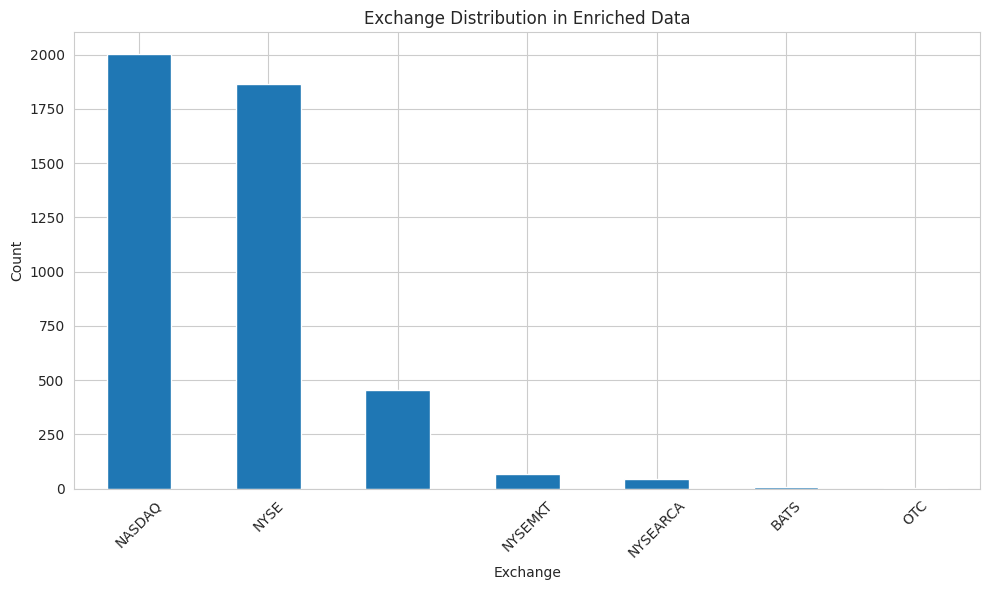

In [16]:
# Exchange distribution in enriched data
if 'sharadar_exchange' in unique_symbols.columns:
    print("=" * 80)
    print("EXCHANGE DISTRIBUTION (in enriched data)")
    print("=" * 80)
    exchange_dist = unique_symbols['sharadar_exchange'].value_counts()
    print(exchange_dist)
    
    # Plot
    plt.figure(figsize=(10, 6))
    exchange_dist.head(10).plot(kind='bar')
    plt.title('Exchange Distribution in Enriched Data')
    plt.xlabel('Exchange')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

CATEGORY DISTRIBUTION (in enriched data)
sharadar_category
Domestic Common Stock                    2728
Domestic Common Stock Primary Class       874
                                          455
CEF                                       257
ETF                                        56
Domestic Common Stock Secondary Class      28
ADR Common Stock                           18
ADR Common Stock Primary Class             12
Domestic Preferred Stock                    4
Canadian Common Stock                       3
ETD                                         2
UNIT                                        2
ADR Common Stock Secondary Class            1
Name: count, dtype: int64


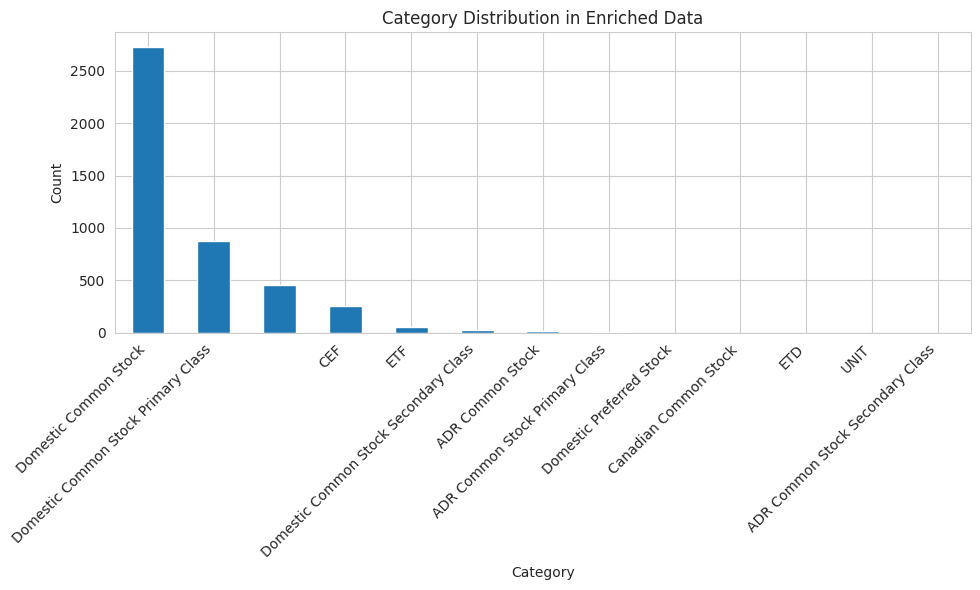

In [17]:
# Category distribution in enriched data
if 'sharadar_category' in unique_symbols.columns:
    print("=" * 80)
    print("CATEGORY DISTRIBUTION (in enriched data)")
    print("=" * 80)
    category_dist = unique_symbols['sharadar_category'].value_counts()
    print(category_dist)
    
    # Plot
    plt.figure(figsize=(10, 6))
    category_dist.plot(kind='bar')
    plt.title('Category Distribution in Enriched Data')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

SECTOR DISTRIBUTION (in enriched data)
sharadar_sector
Healthcare                679
Industrials               664
Financial Services        541
Technology                517
                          455
Consumer Cyclical         356
None                      318
Real Estate               219
Energy                    172
Basic Materials           164
Consumer Defensive        139
Communication Services    132
Utilities                  84
Name: count, dtype: int64


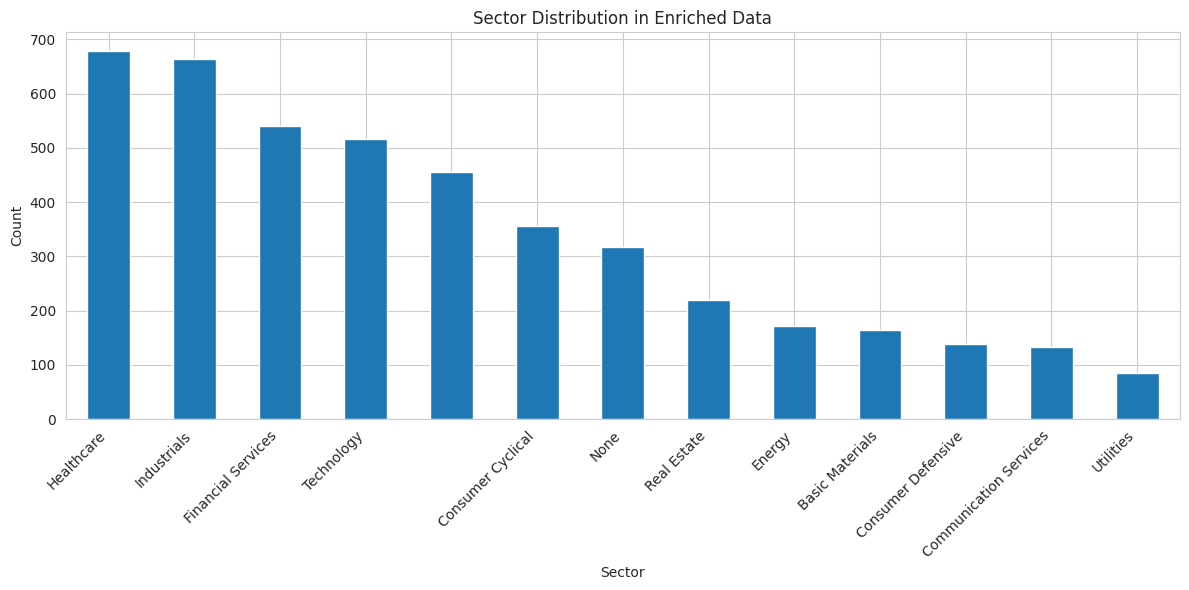

In [18]:
# Sector distribution in enriched data
if 'sharadar_sector' in unique_symbols.columns:
    print("=" * 80)
    print("SECTOR DISTRIBUTION (in enriched data)")
    print("=" * 80)
    sector_dist = unique_symbols['sharadar_sector'].value_counts()
    print(sector_dist)
    
    # Plot
    plt.figure(figsize=(12, 6))
    sector_dist.plot(kind='bar')
    plt.title('Sector Distribution in Enriched Data')
    plt.xlabel('Sector')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 8. Save Enriched CSV

In [19]:
# Save enriched data
print(f"Saving enriched data to: {OUTPUT_CSV}")
enriched.to_csv(OUTPUT_CSV, index=False)

print(f"\n✓ Saved {len(enriched):,} rows to {OUTPUT_CSV}")

Saving enriched data to: /data/csv/20091231_20251118_with_metadata.csv

✓ Saved 9,010,487 rows to /data/csv/20091231_20251118_with_metadata.csv


## 9. Summary Report

In [20]:
print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)
print(f"Original columns: {len(fundamentals.columns)}")
print(f"Enriched columns: {len(enriched.columns)}")
print(f"Metadata columns added: {len(metadata_cols)}")

print("\nNew metadata columns:")
for col in sorted(metadata_cols):
    print(f"  - {col}")

print("\n" + "=" * 80)
print("NEXT STEPS")
print("=" * 80)
print(f"1. Load the enriched CSV into fundamentals.sqlite:")
print(f"   python examples/lseg_fundamentals/load_csv_fundamentals.py")
print(f"")
print(f"2. Use the metadata columns in your Pipeline strategies:")
print(f"   - Filter by exchange: sharadar_exchange")
print(f"   - Filter by category: sharadar_category")
print(f"   - Exclude ADRs: sharadar_is_adr == 0")
print(f"   - Filter by sector: sharadar_sector")
print(f"   - Filter by market cap scale: sharadar_scalemarketcap")
print(f"")
print(f"3. Example Pipeline filter:")
print(f"   exchange_filter = (CustomFundamentals.sharadar_exchange.latest == 'NYSE')")
print(f"   category_filter = (CustomFundamentals.sharadar_category.latest == 'Domestic Common Stock')")
print(f"   no_adr_filter = (CustomFundamentals.sharadar_is_adr.latest == 0)")
print(f"   universe = exchange_filter & category_filter & no_adr_filter")
print("\n✓ Done!")


FINAL SUMMARY
Original columns: 38
Enriched columns: 47
Metadata columns added: 9

New metadata columns:
  - sharadar_category
  - sharadar_exchange
  - sharadar_industry
  - sharadar_is_adr
  - sharadar_location
  - sharadar_scalemarketcap
  - sharadar_sector
  - sharadar_sicindustry
  - sharadar_sicsector

NEXT STEPS
1. Load the enriched CSV into fundamentals.sqlite:
   python examples/lseg_fundamentals/load_csv_fundamentals.py

2. Use the metadata columns in your Pipeline strategies:
   - Filter by exchange: sharadar_exchange
   - Filter by category: sharadar_category
   - Exclude ADRs: sharadar_is_adr == 0
   - Filter by sector: sharadar_sector
   - Filter by market cap scale: sharadar_scalemarketcap

3. Example Pipeline filter:
   exchange_filter = (CustomFundamentals.sharadar_exchange.latest == 'NYSE')
   category_filter = (CustomFundamentals.sharadar_category.latest == 'Domestic Common Stock')
   no_adr_filter = (CustomFundamentals.sharadar_is_adr.latest == 0)
   universe = exc

## 10. Sample Data for AAPL

View the last 10 rows of enriched data for AAPL to see all columns with metadata.

In [28]:
# Get last 10 rows for AAPL
print("=" * 80)
print("LAST 10 ROWS FOR AAPL (with all columns)")
print("=" * 80)

if 'IBM' in enriched['Symbol'].values:
    aapl_data = enriched[enriched['Symbol'] == 'AMZN'].tail(10)
    
    print(f"\nShowing last 10 rows of {len(enriched[enriched['Symbol'] == 'AMZN'])} total rows for AAPL")
    print(f"Date range: {aapl_data['Date'].min()} to {aapl_data['Date'].max()}")
    print(f"\nColumns: {len(aapl_data.columns)}")
    print("\n" + "=" * 80)
    
    # Display with pandas settings for full visibility
    with pd.option_context('display.max_columns', None,
                          'display.max_rows', None,
                          'display.width', None,
                          'display.max_colwidth', 50):
        print(aapl_data)
    
    print("\n" + "=" * 80)
    print("AAPL METADATA SUMMARY")
    print("=" * 80)
    
    # Show just the metadata columns for clarity
    metadata_cols_display = [col for col in aapl_data.columns if col.startswith('sharadar_')]
    if metadata_cols_display:
        aapl_metadata = aapl_data[['Date', 'Symbol'] + metadata_cols_display].tail(1)
        print("\nSharadar Metadata for AAPL:")
        for col in metadata_cols_display:
            value = aapl_metadata[col].iloc[0]
            print(f"  {col:40s}: {value}")
else:
    print("AAPL not found in enriched data")

LAST 10 ROWS FOR AAPL (with all columns)

Showing last 10 rows of 3996 total rows for AAPL
Date range: 2025-11-05 to 2025-11-18

Columns: 47

              Date Symbol Instrument  RefPriceClose   RefVolume  \
478258  2025-11-05   AMZN    AMZN.OQ         250.20  13693771.0   
478259  2025-11-06   AMZN    AMZN.OQ         243.04  15745818.0   
478260  2025-11-07   AMZN    AMZN.OQ         244.41  13318525.0   
478261  2025-11-10   AMZN    AMZN.OQ         248.40  11791912.0   
478262  2025-11-11   AMZN    AMZN.OQ         249.10   7803812.0   
478263  2025-11-12   AMZN    AMZN.OQ         244.20  10802252.0   
478264  2025-11-13   AMZN    AMZN.OQ         237.58  14015342.0   
478265  2025-11-14   AMZN    AMZN.OQ         234.69  12949157.0   
478266  2025-11-17   AMZN    AMZN.OQ         232.87  16696201.0   
478267  2025-11-18   AMZN    AMZN.OQ         222.55  18614526.0   

       CompanyCommonName  EnterpriseValue_DailyTimeSeries_  CompanyMarketCap  \
478258    Amazon.com Inc                